In [1]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

# 8 The Lapped Bi-orthogonal Transform (LBT)

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [2]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [3]:
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.dct import dct_ii

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

In [4]:
# your code here
def POT(X,N,plot_Xp = 0, plot_Y = 0,plot_Z = 0,s = 1):
    Xp = X.copy()
    Xc = X.copy()
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T
    for i in range(256-N):
        for j in range(256-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]
    if plot_Xp == 1:
        fig, ax = plt.subplots()
        plot_image(Xc*0.5, ax=ax)
        plt.title('s = {}'.format(s))
    # Then do DCT (XP)
    Y = colxfm(colxfm(Xc, cn).T,cn).T
    if plot_Y == 1:
        fig, ax = plt.subplots()
        plot_image(Y, ax=ax)
    # Then do IDCT
    Z = colxfm(colxfm(Y.T, cn.T).T, cn.T)
    if plot_Z == 1:
        fig, ax = plt.subplots()
        plot_image(Z, ax=ax)
    # Finally do Y*Pr
    Zp = Z
    Z2 = Z
    Zp = colxfm(Zp[:,t].T,pr.T).T
    Zp = colxfm(Zp[t,:],pr.T)
    for i in range(256-N):
        for j in range(256-N):
            Z2[int(i+N/2),int(j+N/2)] = Zp[i,j]
    return Z2

1.0683404373096357e-13


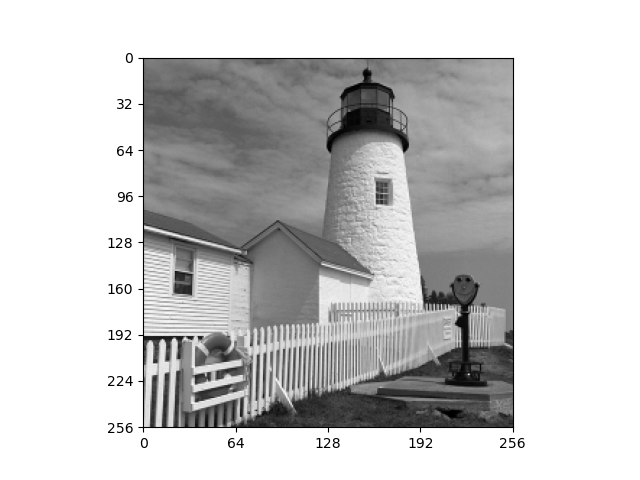

In [5]:
N = 8
Z = POT(X,N)
fig, ax = plt.subplots()
plot_image(Z, ax=ax)
print(np.std(X-Z))

In [6]:
def DCT(X,N):
    cn = dct_ii(N)
    Y = colxfm(colxfm(X, cn).T,cn).T
    Z = colxfm(colxfm(Y.T, cn.T).T, cn.T)
    return Z

1.0295842745618262e-13


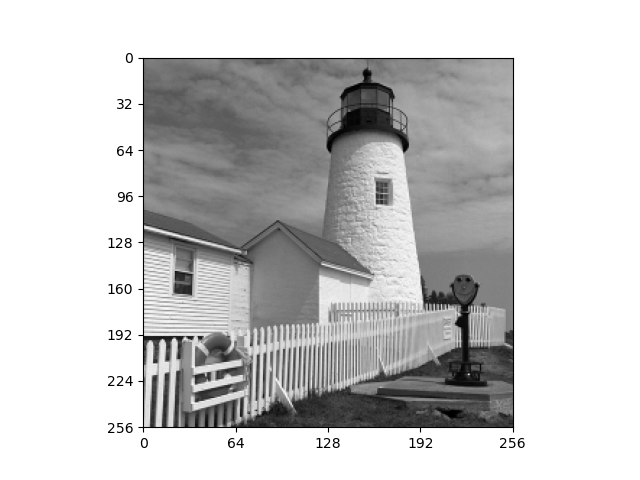

In [7]:
N = 8
Z = DCT(X,N)
fig, ax = plt.subplots()
plot_image(Z, ax=ax)
print(np.std(X-Z))

Tony: Direct DCT obtains slightly lower RMS than POT

## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

In [8]:
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.dct import regroup
def dctbpp(Yr, N):
    sum = 0
    # Your code here
    for i in range(N):
        for j in range(N):
            Ys = Yr[int(256/N)*i:int(256/N)*(i+1),int(256/N)*j:int(256/N)*(j+1)]
            sum += (256/N)*(256/N)*bpp(Ys)
    return sum

In [9]:
from scipy.optimize import minimize

In [10]:
Xq = quantise(X,17)
RMS_X = np.std(X-Xq)
def objective(step):
    Xp = X.copy()
    Xc = X.copy()
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T
    for i in range(256-N):
        for j in range(256-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]
    
    Y = colxfm(colxfm(Xc, cn).T,cn).T
    
    Yq = quantise(Y,step)
    Yr = regroup(Yq,N)
    # Then do IDCT
    Z = colxfm(colxfm(Yq.T, cn.T).T, cn.T)
    # Finally do Y*Pr
    Zp = Z
    Z2 = Z
    Zp = colxfm(Zp[:,t].T,pr.T).T
    Zp = colxfm(Zp[t,:],pr.T)
    for i in range(256-N):
        for j in range(256-N):
            Z2[int(i+N/2),int(j+N/2)] = Zp[i,j]
    RMS_Z = np.std(X-Z2)
    return abs(np.abs(RMS_X - RMS_Z))

In [11]:
def LBT(X,N,s):
    Xq = quantise(X,17)
    e_xq = 256*256*bpp(Xq)
    RMS_X = np.std(X-Xq)
    Xp = X.copy()
    Xc = X.copy()
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T
    for i in range(256-N):
        for j in range(256-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]
    # Then do DCT (XP)
    Y = colxfm(colxfm(Xc, cn).T,cn).T
    
    result = minimize(objective, 10, method='Nelder-Mead')
    final_step = result.x[0]

    Yq = quantise(Y,final_step)
    Yr = regroup(Yq,N)
    Z = colxfm(colxfm(Yq.T, cn.T).T, cn.T)
    Zp = Z
    Z2 = Z
    Zp = colxfm(Zp[:,t].T,pr.T).T
    Zp = colxfm(Zp[t,:],pr.T)
    for i in range(256-N):
        for j in range(256-N):
            Z2[int(i+N/2),int(j+N/2)] = Zp[i,j]
    e_z = dctbpp(Yr,N)
    return Z2,final_step,e_xq/e_z

In [12]:
#def obj2(s):
#    Z,step,ratio =  LBT(X,N,s)
#    return ratio
#result = minimize(obj2, np.sqrt(2), method='Nelder-Mead',bounds = [(1,2)])
#final_s = result.x[0]
#print(final_s)


1.3 3.1070610563628738


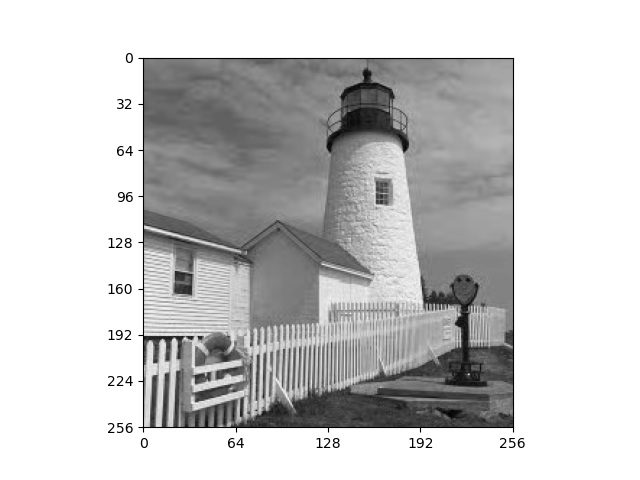

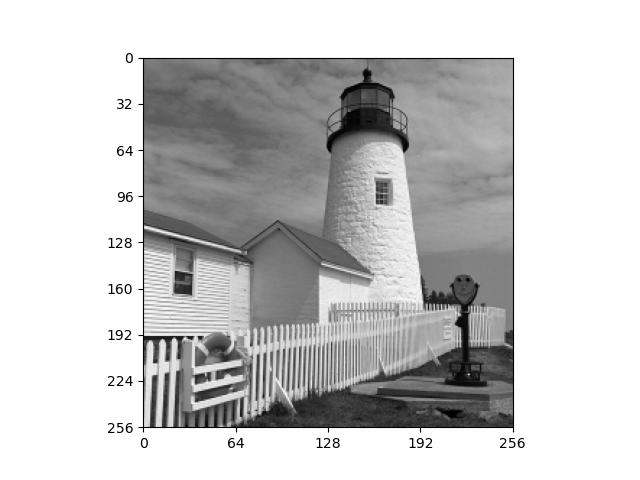

In [13]:
ratio_max = 0
counter = 0
for s in np.linspace(1,2,11):
    Z,step,ratio =  LBT(X,N,s)
    counter +=1
    if counter % 30 == 0:    
        print(s)
    if ratio_max < ratio:
        ratio_max = ratio
        s_good = s
        Z_good = Z
        
print(s_good,ratio_max)
fig, ax = plt.subplots()
plot_image(Z_good, ax=ax)
fig, ax = plt.subplots()
plot_image(X, ax=ax)

In [14]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
print(np.std(Z_good-X))

4.8611713457921395


Tony: Therefore, the s=1.31 which is close to root 2 

The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

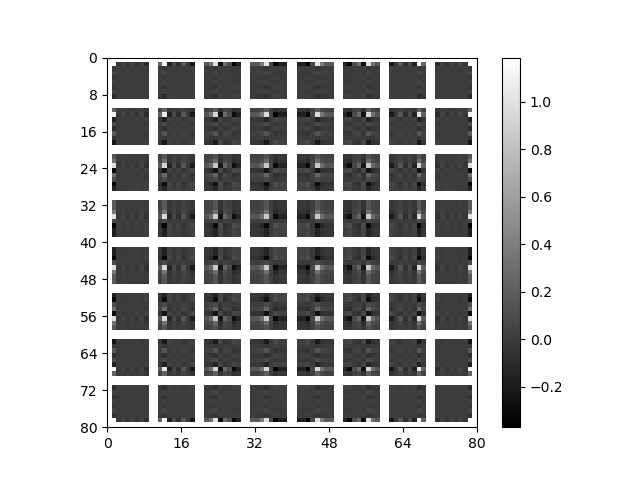

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}


In [15]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax)

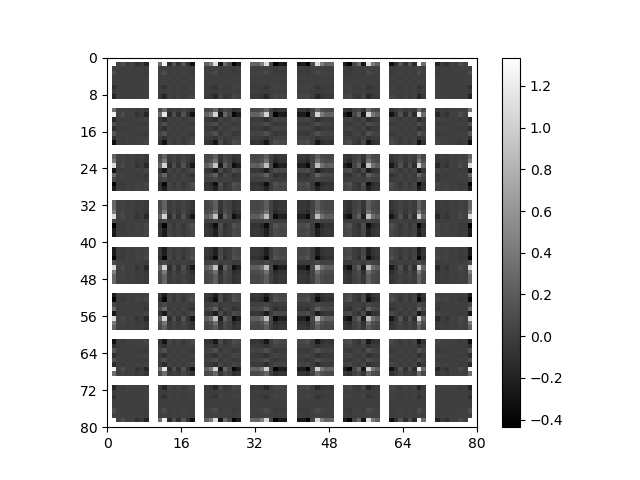

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}


In [16]:
Pf, Pr = pot_ii(8,s = 2)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax)

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

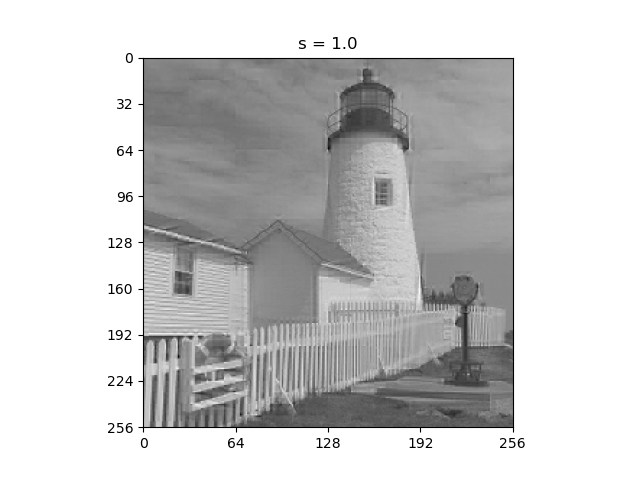

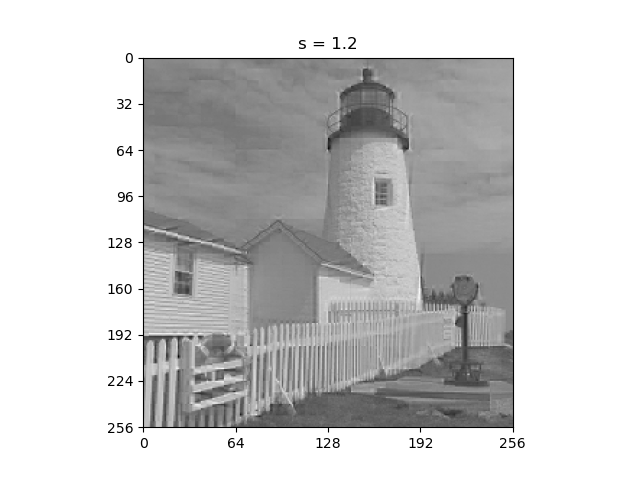

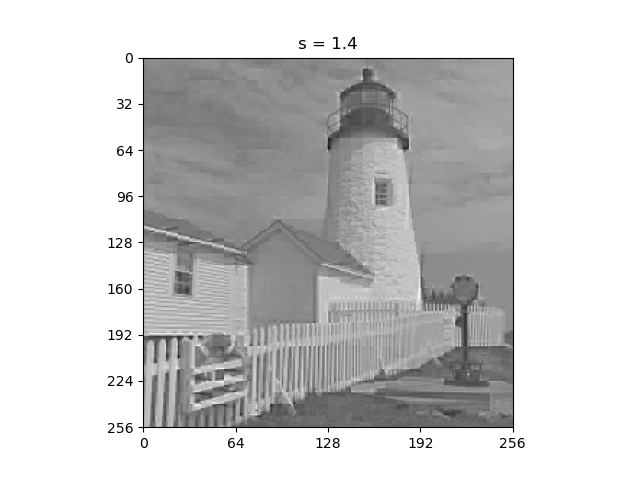

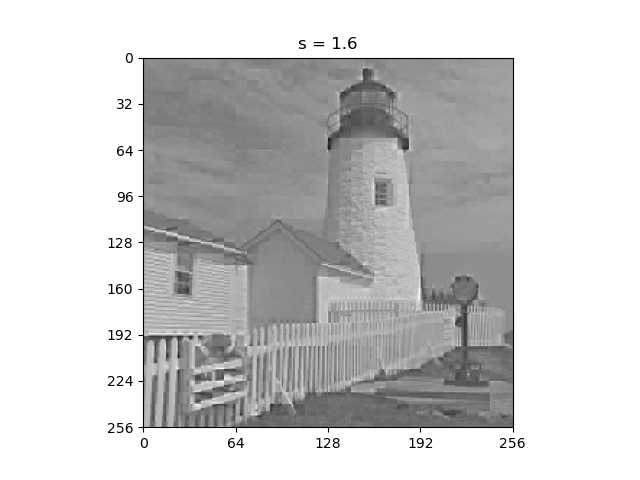

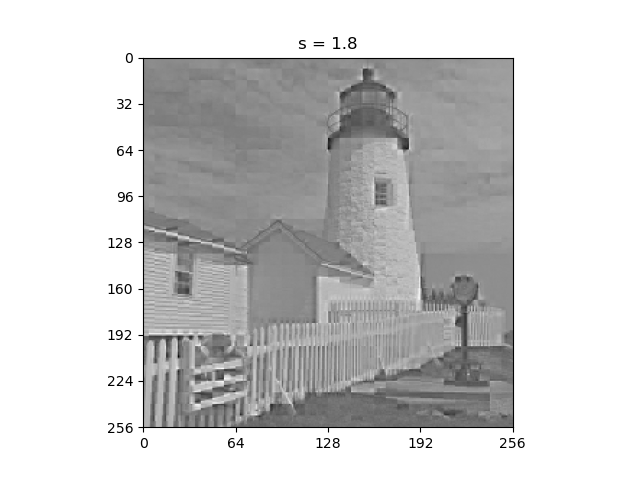

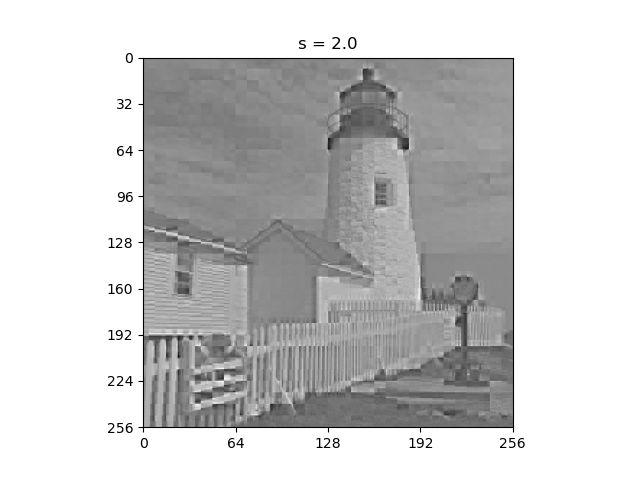

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}


In [17]:
for i in np.linspace(1,2,6):
    Z = POT(X,N,plot_Xp = 1,s =i)


Lmao my eyes are blind, I cannot tell. s = 1 is very differnt from s = 2 tho.

With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

In [18]:
def LBT_s(X,N,s = np.sqrt(2),expect_error = 0.01):
    Xq = quantise(X,17)
    e_xq = 256*256*bpp(Xq)
    RMS_X = np.std(X-Xq)
    Xp = X.copy()
    Xc = X.copy()
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T
    for i in range(256-N):
        for j in range(256-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]
    # Then do DCT (XP)
    Y = colxfm(colxfm(Xc, cn).T,cn).T
    
    goodstep = []
    for step in range(500):
        step = step/10
        Yq = quantise(Y,step)
        Yr = regroup(Yq,N)
        # Then do IDCT
        Z = colxfm(colxfm(Yq.T, cn.T).T, cn.T)
        # Finally do Y*Pr
        Zp = Z
        Z2 = Z
        Zp = colxfm(Zp[:,t].T,pr.T).T
        Zp = colxfm(Zp[t,:],pr.T)
        for i in range(256-N):
            for j in range(256-N):
                Z2[int(i+N/2),int(j+N/2)] = Zp[i,j]
        RMS_Z = np.std(X-Z2)
        e = abs(RMS_X - RMS_Z) 
        if e < expect_error:
            goodstep.append([step,e])
    if len(goodstep) == 0:
        raise ValueError("Cannot find a good step")
    min_e = 999
    for i in goodstep:
        if min_e > i[1]:
            min_e = i[1]
            final_step = i[0]

    Yq = quantise(Y,final_step)
    Yr = regroup(Yq,N)
    Z = colxfm(colxfm(Yq.T, cn.T).T, cn.T)
    Zp = Z
    Z2 = Z
    Zp = colxfm(Zp[:,t].T,pr.T).T
    Zp = colxfm(Zp[t,:],pr.T)
    for i in range(256-N):
        for j in range(256-N):
            Z2[int(i+N/2),int(j+N/2)] = Zp[i,j]
    e_z = dctbpp(Yr,N)
    return Z2,e_xq/e_z

2.9151592173283993 4
3.1016409595965375 8
2.900638586210824 16


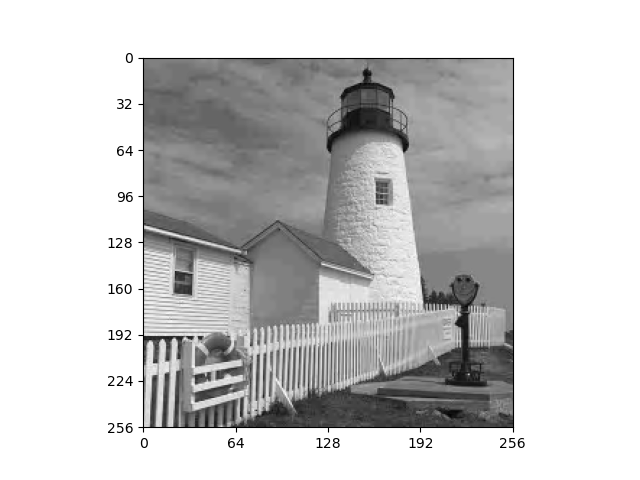

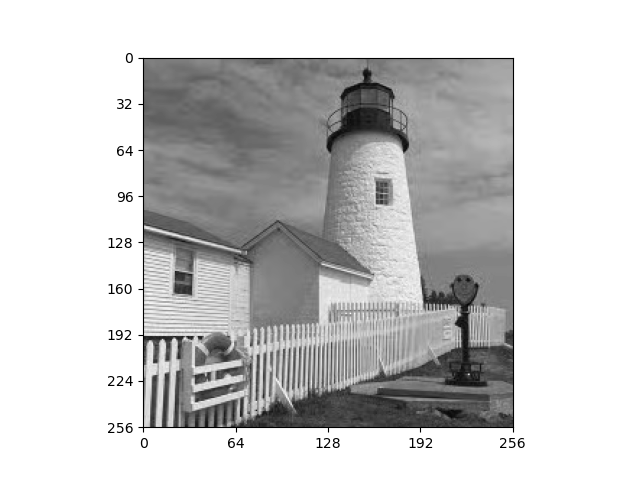

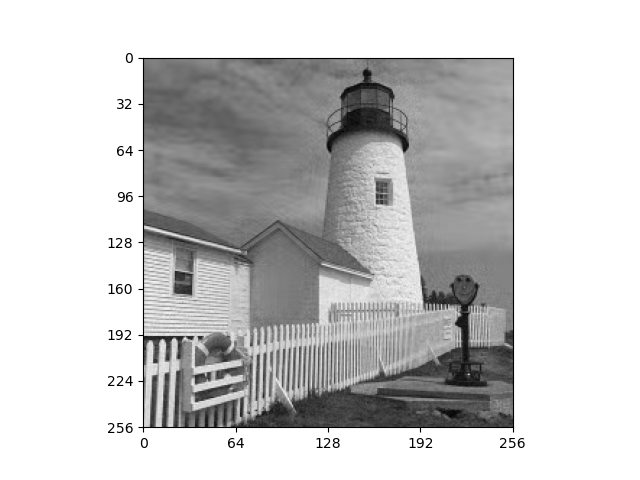

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 4.147200107574463, 'type': 'set_device_pixel_ratio'}


In [19]:
for N in [4,8,16]:    
    Z,ratio = LBT_s(X,N)
    print(ratio,N)
    fig, ax = plt.subplots()
    im_obj = plot_image(Z, ax=ax)
    

Tony: Actually it is hard to tell the difference. So I might just go for the one with highest compression ratio